In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xlrd.xldate import xldate_as_datetime
from datetime import datetime

from scipy.signal import find_peaks

Attached are three sets of data related to the marketing channel performance of a hypothetical business with similar seasonality to ours.  

In [2]:
df_1 = pd.read_csv("Data 1.csv")
df_2 = pd.read_csv("Data 2.csv")
df_3 = pd.read_csv("Data 3.csv")

#### Please review this information, and prepare the following: 

1) Analysis of the historical performance of the company and it's marketing efforts 

2) Recommendation of which channel(s) the company should focus on in the next year (2018) 

3) Cost and Revenue forecast for the entire company (all channels combined) by day for the two weeks leading up to Valentine's Day 2018 

4) Explanation of any assumptions you make, potential risks to your recommendations/analysis, and additional data you would want to look at to improve the accuracy of your analysis/recommendations 

#### Definitions: 

Date – Date the order was placed 

Channel – The marketing channel 

Sessions – The amount of traffic to the site 

Transactions – The order count 

Revenue – The association amount of money made. 

AOV – Average order volume 

CPA – Cost per acquisition (order) 

In [3]:
df_1.head()

,Date,Channel,Conversion Rate,Transactions,AOV,CPA
0,42404,Channel B,0.091545,1313,60.41,15
1,42401,Channel C,0.070204,936,64.96,8
2,42408,Channel D,0.153458,1885,69.67,18
3,42408,Channel C,0.185907,1653,66.36,7
4,42404,Channel D,0.129013,1113,68.35,19


In [4]:
df_2.head()

,Date,Channel,Sessions,Revenue,AOV,CPA
0,42735,Channel A,1377,19327,74.70,8
1,42735,Channel B,1161,8628,90.79,34
2,42735,Channel C,2409,15758,79.11,5
3,42735,Channel D,2563,15708,81.00,19
4,42734,Channel A,2416,37456,76.96,4


In [5]:
df_3.head()

,Date,Channel,Sessions,Transactions,AOV,CPA
0,12/31/2017,Channel A,1155,263,58.97,10
1,12/31/2017,Channel B,1311,108,72.06,27
2,12/31/2017,Channel C,1322,115,56.51,5
3,12/31/2017,Channel D,2320,198,63.71,14
4,12/30/2017,Channel A,1674,341,59.21,3


In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
Date               156 non-null int64
Channel            156 non-null object
Conversion Rate    156 non-null float64
Transactions       156 non-null int64
AOV                156 non-null float64
CPA                156 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 7.4+ KB


In [7]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 6 columns):
Date        1308 non-null int64
Channel     1308 non-null object
Sessions    1308 non-null int64
Revenue     1308 non-null int64
AOV         1308 non-null float64
CPA         1308 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 61.4+ KB


In [8]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 6 columns):
Date            1400 non-null object
Channel         1400 non-null object
Sessions        1400 non-null int64
Transactions    1400 non-null int64
AOV             1400 non-null float64
CPA             1400 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 65.7+ KB


In [9]:
# Clean Date data format to datetime format for Data 1 and Data 2
df_1['Date'] = df_1.Date.apply(lambda x: xldate_as_datetime(x, 0))
df_2['Date'] = df_2.Date.apply(lambda x: xldate_as_datetime(x, 0))
df_3['Date'] = df_3.Date.apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

# Generate new column, Cost, by multiplying AOV and CPA
df_1['cost'] = df_1['AOV'] * df_1['CPA']
df_2['cost'] = df_2['AOV'] * df_2['CPA']
df_3['cost'] = df_3['AOV'] * df_3['CPA']

# Add Month
df_1['Month'] = df_1.Date.apply(lambda x: x.month())
df_2['Month'] = df_2.Date.apply(lambda x: x.month())
df_3['Month'] = df_3.Date.apply(lambda x: x.month())

# Add day
df_1['Day'] = df_1.Date.apply(lambda x: x.day())
df_2['Day'] = df_2.Date.apply(lambda x: x.day())
df_3['Day'] = df_3.Date.apply(lambda x: x.day())

# Add Weekday of Week
df_1['Weekday'] = df_1.Date.apply(lambda x: x.weekday())
df_2['Weekday'] = df_2.Date.apply(lambda x: x.weekday())
df_3['Weekday'] = df_3.Date.apply(lambda x: x.weekday())

# Add feature Isweekday
df_1['IsWeekday'] = df_1.Day.apply(lambda x: x < 5)
df_2['IsWeekday'] = df_2.Day.apply(lambda x: x < 5)
df_3['IsWeekday'] = df_3.Day.apply(lambda x: x < 5)

In [10]:
# Sort by time
dfs = [df_1, df_2, df_3]
for df in dfs:
    df.sort_values(by=['Date', 'Channel'], inplace=True)

# Analysis of the historical performance

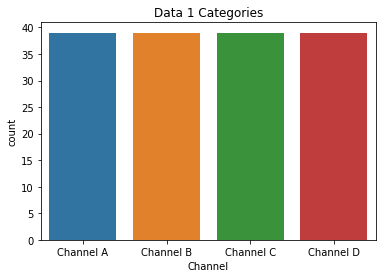

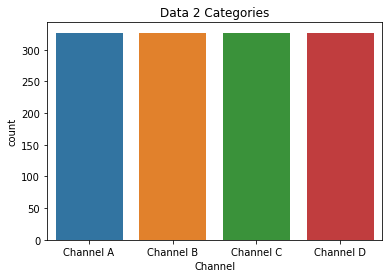

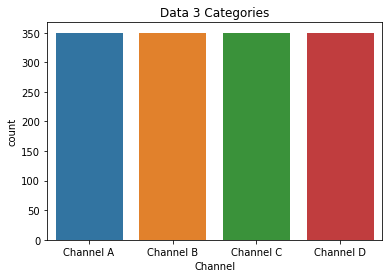

In [11]:
plt.title('Data 1 Categories')
sns.countplot(df_1.Channel)
plt.show()
plt.title('Data 2 Categories')
sns.countplot(df_2.Channel)
plt.show()
plt.title('Data 3 Categories')
sns.countplot(df_3.Channel)
plt.show()

In [12]:
# see if there is any missing dates in Datasets
for idx, df in enumerate(dfs):
    print('Data', idx + 1)
    print('# of Missing Dates:', len(pd.date_range(start = df.Date.values[0], 
                  end = df.Date.values[-1]).difference(pd.unique(df.Date.values))))
    print('Start Date:', str(df.Date.values[0])[:10])
    print('End Date:', str(df.Date.values[-1])[:10], '\n')

Data 1
# of Missing Dates: 0
Start Date: 2016-01-01
End Date: 2016-02-08 

Data 2
# of Missing Dates: 0
Start Date: 2016-02-09
End Date: 2016-12-31 

Data 3
# of Missing Dates: 0
Start Date: 2017-01-16
End Date: 2017-12-31 



Based on the above result, Data 1 and Data 2 have 

In [83]:
def plot_channels(df, dataname):
    channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']
    time_data = []
    AOV_data = []
    CPA_data = []
    cost_data = []
    for channel in channels:
        temp = df_1[df_1.Channel == channel]
        time_data.append(temp.Date.values)
        AOV_data.append(temp.AOV.values)
        CPA_data.append(temp.CPA.values)
        cost_data.append(temp.cost.values)
        
    # plot time vs AOV for each channel
    plt.figure()
    plt.title('Time VS AOV ' + dataname)
    for i in range(len(channels)):
        plt.scatter(time_data[i], AOV_data[i])
    plt.legend(channels)
    plt.gcf().autofmt_xdate()
    plt.ylabel('Average order volume')
    plt.xlim(time_data[0][0], time_data[0][-1])
    plt.show()
    
    # plot time vs CPA for each channel
    plt.figure()
    plt.title('time vs CPA ' + dataname)
    for i in range(len(channels)):
        plt.scatter(time_data[i], CPA_data[i])
    plt.legend(channels)
    plt.ylabel('CPA – Cost per acquisition (order)')
    plt.gcf().autofmt_xdate()
    plt.xlim(time_data[0][0], time_data[0][-1])
    plt.show()
    
    # plot time vs AOV * CPA for each channel
    plt.figure()
    plt.title('time vs cost (AOV * CPA) ' + dataname)
    for i in range(len(channels)):
        plt.scatter(time_data[i], cost_data[i])
    plt.legend(channels)
    plt.ylabel('cost (CPA * AOV)')
    plt.gcf().autofmt_xdate()
    plt.xlim(time_data[0][0], time_data[0][-1])
    plt.show()

def plot_channels_feature(df, feature, method='scatter'):
    channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']
    time_data = []
    feature_data = []

    for channel in channels:
        temp = df[df.Channel == channel]
        time_data.append(temp.Date.values)
        feature_data.append(temp[feature].values)
    
    plt.figure()
    plt.title('time vs {0}'.format(feature))
    for i in range(len(channels)):
        if (method == 'scatter'):
            plt.scatter(time_data[i], feature_data[i])
        else:
            plt.plot(time_data[i], feature_data[i])
    plt.legend(channels)
    plt.ylabel(feature)
    plt.gcf().autofmt_xdate()
    plt.xlim(time_data[0][0], time_data[0][-1])
    plt.show()
    
def plot_weekday_feature(df, feature, method='scatter'):
    """
    plot feature against weekday and weekend data
    """
    plt.figure()
    plt.title('Time VS ' + feature)
    weekday = df[(df.Weekday)]
    weekend = df[(df.Weekday == False)]
    plt.scatter(weekday.Date.values, weekday[feature].values)
    plt.scatter(weekend.Date.values, weekend[feature].values)
    plt.legend(['Weekday', 'Weekend'])
    plt.gcf().autofmt_xdate()
    plt.ylabel(feature)
    plt.xlim(weekday.Date.values[0], weekday.Date.values[-1])
    plt.show()
    
# generate corr map for each channel and see if there are different insights
def channel_corrmap(df):
    channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']
    
    for channel in channels:
        temp = df[df.Channel == channel]
        plt.title(channel)
        sns.heatmap(temp.corr())
        plt.show()

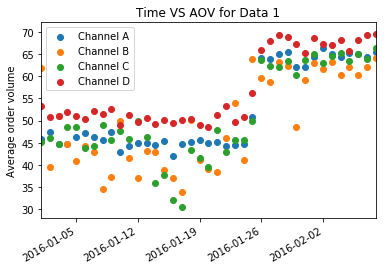

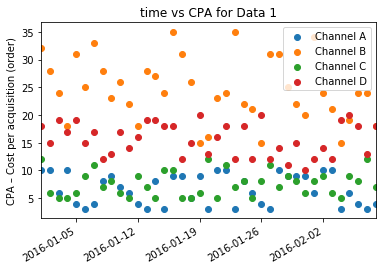

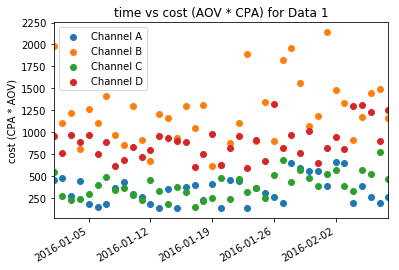

In [84]:
# Data 1
plot_channels(df_1, 'for Data 1')

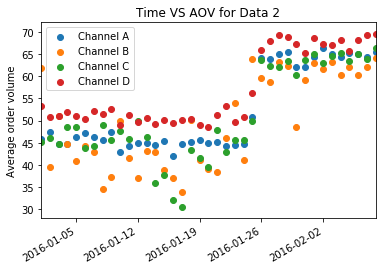

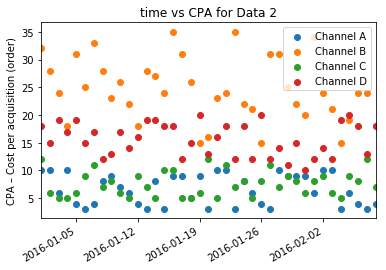

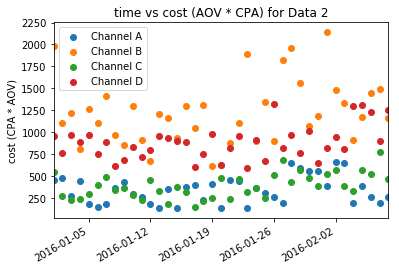

In [85]:
# Data 2
plot_channels(df_2, 'for Data 2')

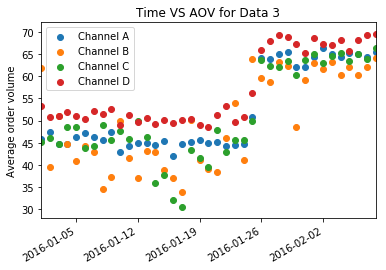

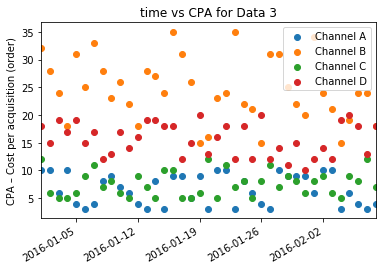

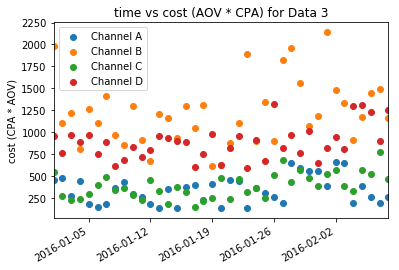

In [86]:
# Data 3
plot_channels(df_3, 'for Data 3')

### More Investigation into Data 1
Since each dataset contains different features, it is reasonable to investigate each data more intensely.

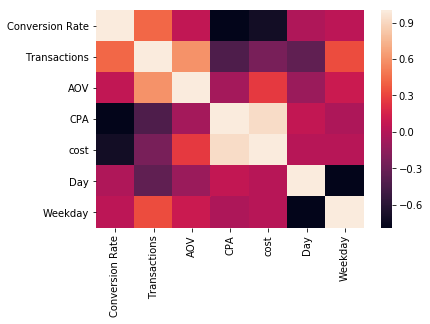

In [87]:
sns.heatmap(df_1.corr())

In [88]:
df_1.corr()

,Conversion Rate,Transactions,AOV,CPA,cost,Day,Weekday
Conversion Rate,1.000000,0.432564,0.059208,-0.786420,-0.705356,-0.020741,0.041042
Transactions,0.432564,1.000000,0.595810,-0.424390,-0.238530,-0.344163,0.335139
AOV,0.059208,0.595810,1.000000,-0.062885,0.261803,-0.105082,0.098774
CPA,-0.786420,-0.424390,-0.062885,1.000000,0.927517,0.065871,-0.027095
cost,-0.705356,-0.238530,0.261803,0.927517,1.000000,0.020320,0.014209
Day,-0.020741,-0.344163,-0.105082,0.065871,0.020320,1.000000,-0.790719
Weekday,0.041042,0.335139,0.098774,-0.027095,0.014209,-0.790719,1.000000


1) CPA and Conversion Rate have a negative correlation.

2) Transaction and CPA have an inverse correlation.

3) There is no/little correlation between AOV and Conversion Rate.

4) There is no/little correlation between AOV and CPA.

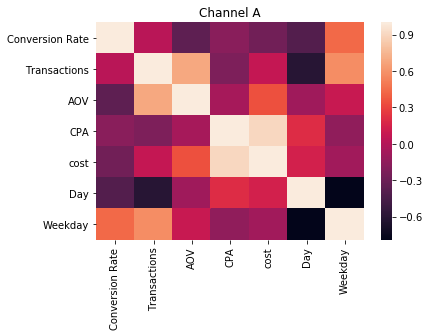

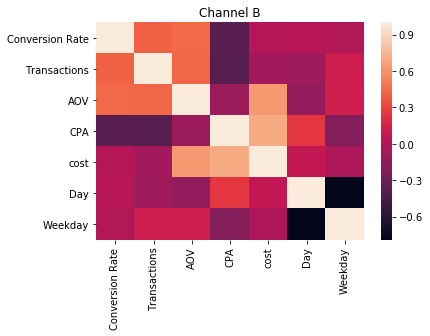

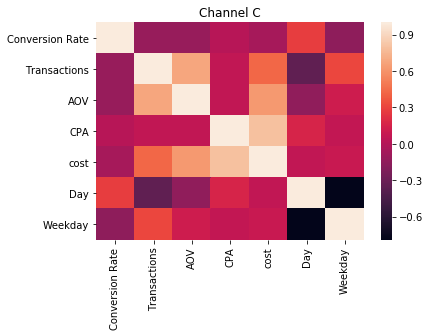

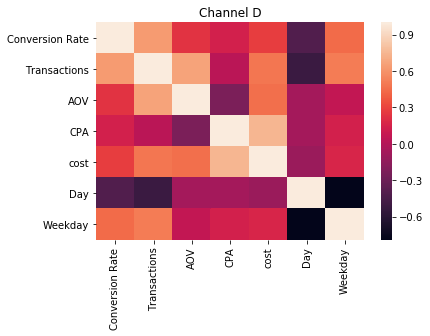

In [89]:
channel_corrmap(df_1)

After breaking down the correlation map for each channel, transactions and AOV are more closely correlated compared to other features. This makes sense becasue  the more people visit the site (AOV), the more transactions there should be. 

Channels A & C 

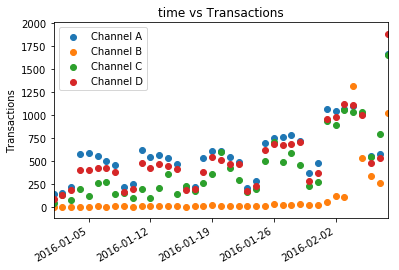

In [90]:
# transaction column
channels = ['Channel A', 'Channel B', 'Channel C', 'Channel D']

# plot time vs transaction for each channel
plot_channels_feature(df_1, "Transactions")

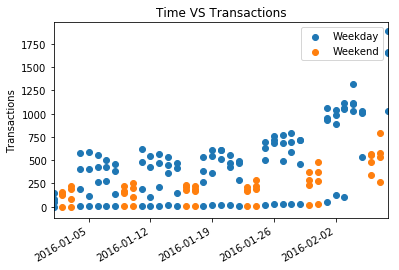

In [91]:
# To be continued
# The oscillation might be due to weekday vs weekend

# plot time vs transaction for each channel
plot_weekday_feature(df_1, 'Transactions')

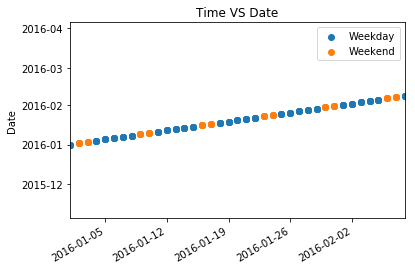

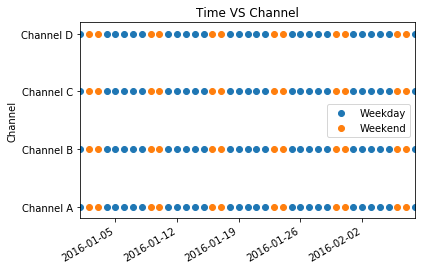

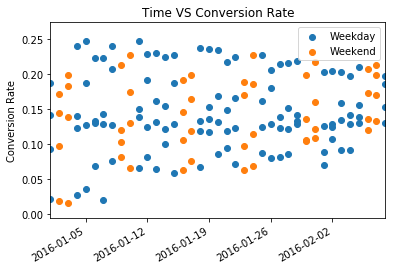

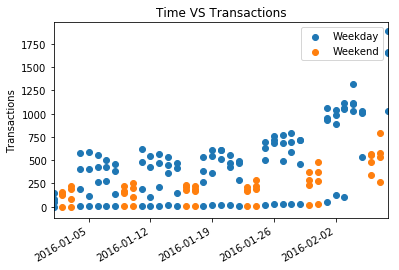

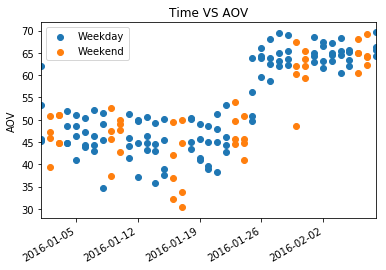

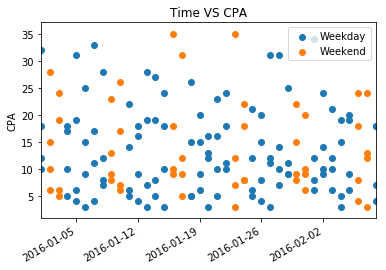

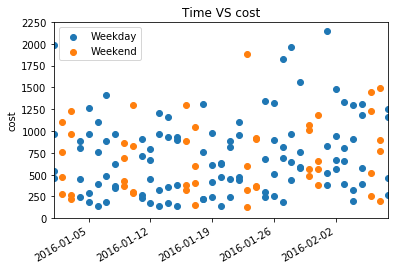

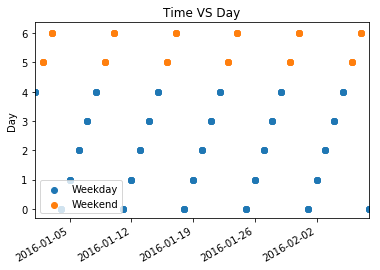

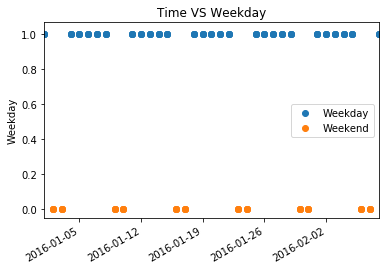

In [92]:
for feature in df_1.columns.values:
    plot_weekday_feature(df_1, feature)

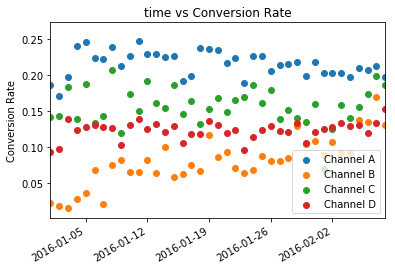

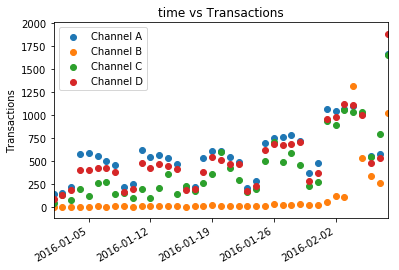

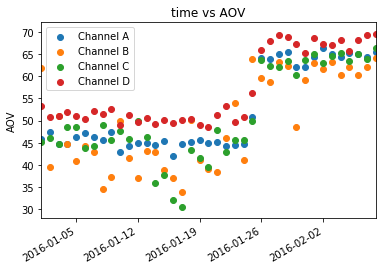

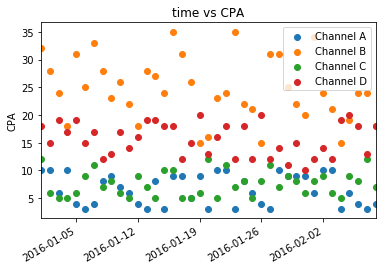

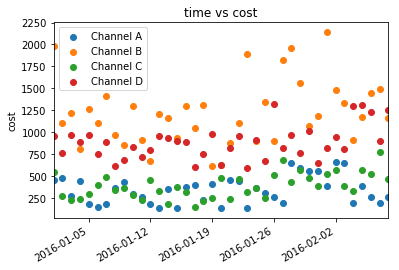

In [99]:
for feature in ['Conversion Rate', 'Transactions', 'AOV', 'CPA', 'cost']:
    plot_channels_feature(df_1, feature)

### More Investigation into Data 2

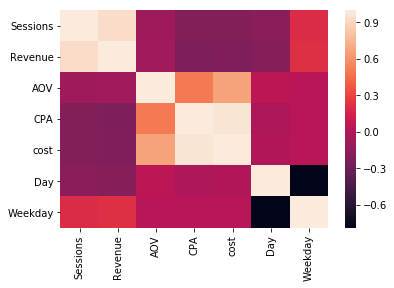

In [23]:
sns.heatmap(df_2.corr())

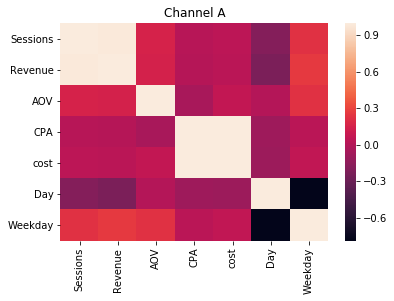

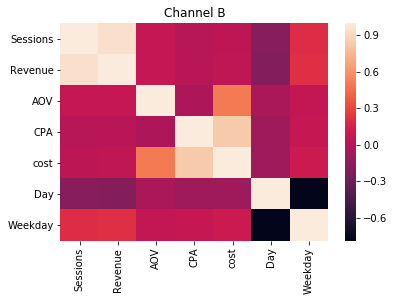

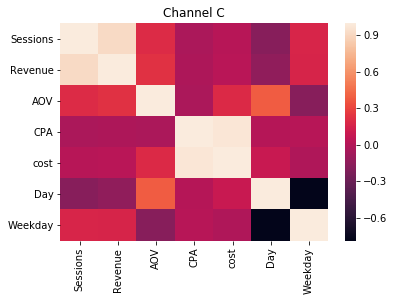

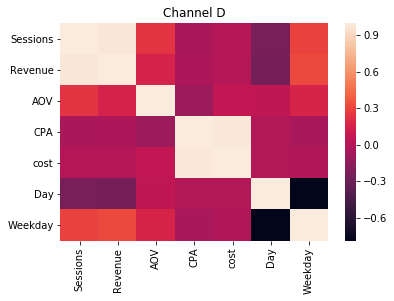

In [25]:
channel_corrmap(df_2)

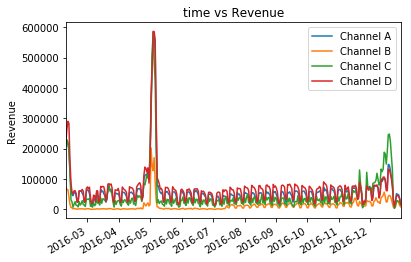

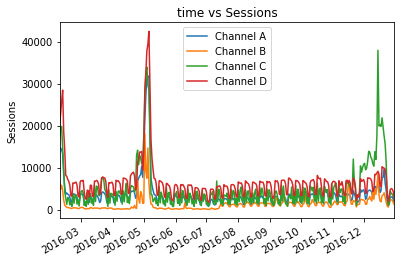

In [63]:
# Rvenue column
# plot time vs Rvenue for each channel
plot_channels_feature(df_2, 'Revenue', 'line')

# Sessions column
# plot time vs Sessions for each channel
plot_channels_feature(df_2, 'Sessions', 'line')

As shown in the correlation graph, "Revenue" and "Transaction" features are extremely correlated. They show to have the same trend with time. It might be due to the more people visiting the website, the higher chance there are more purchase.

Mother's Day and Valentines' Day

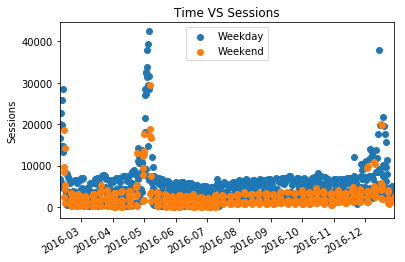

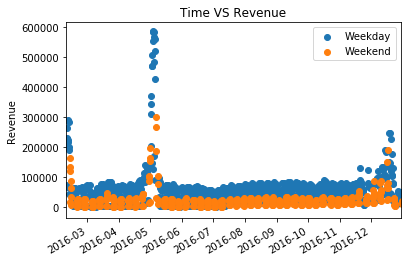

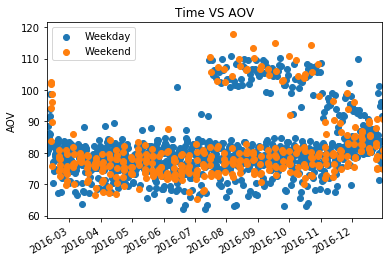

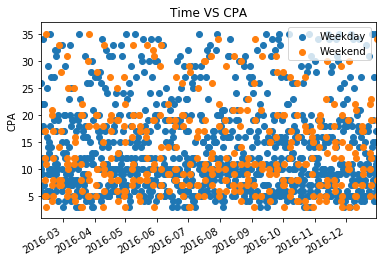

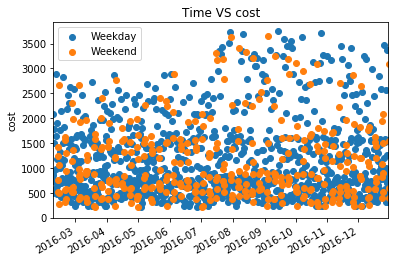

In [97]:
for feature in ['Sessions', 'Revenue', 'AOV', 'CPA', 'cost']:
    plot_weekday_feature(df_2, feature)

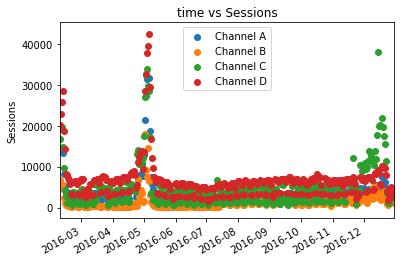

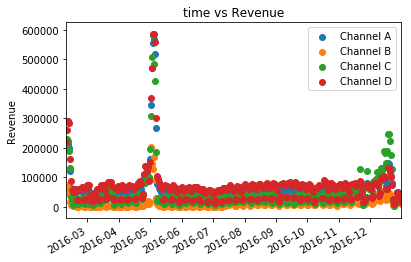

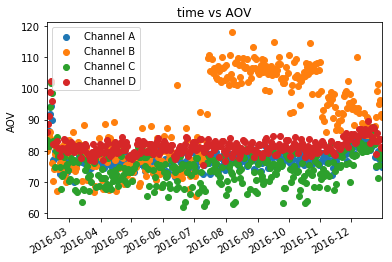

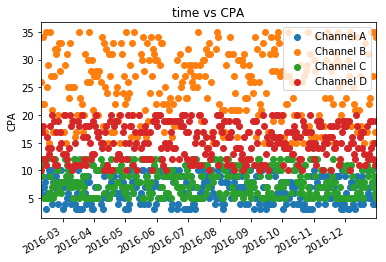

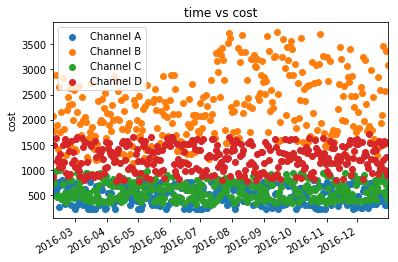

In [96]:
for feature in ['Sessions', 'Revenue', 'AOV', 'CPA', 'cost']:
    plot_channels_feature(df_2, feature)

### More Investigation into Data 3

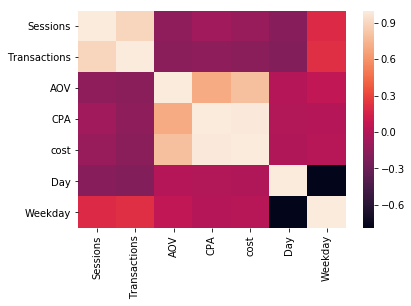

In [29]:
sns.heatmap(df_3.corr())

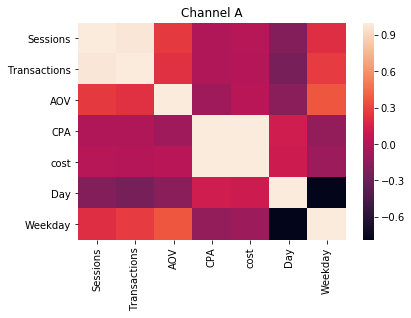

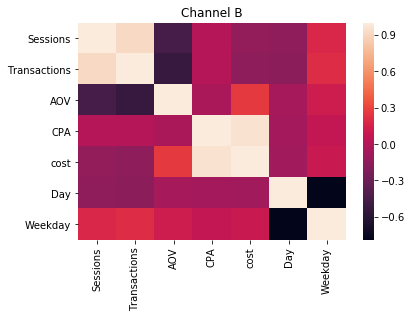

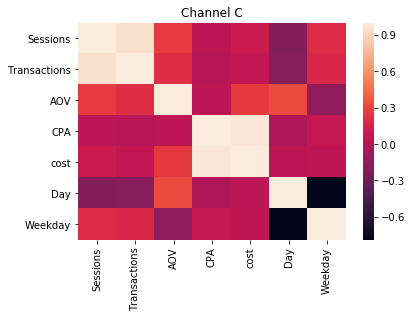

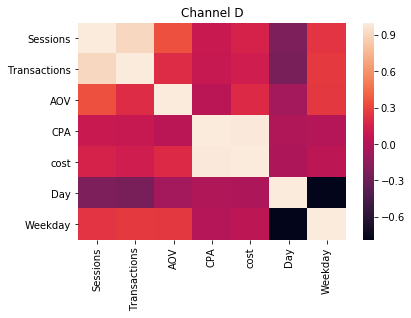

In [30]:
channel_corrmap(df_3)

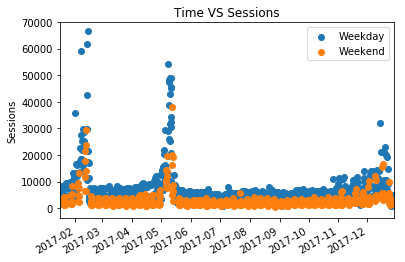

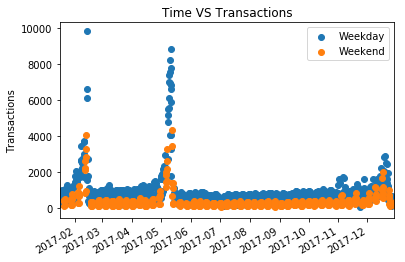

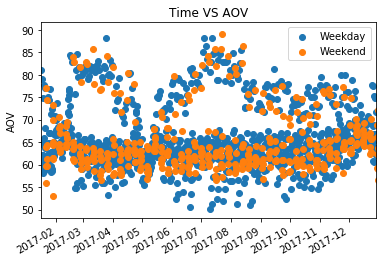

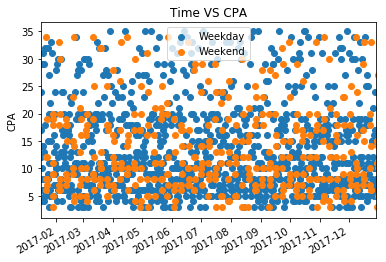

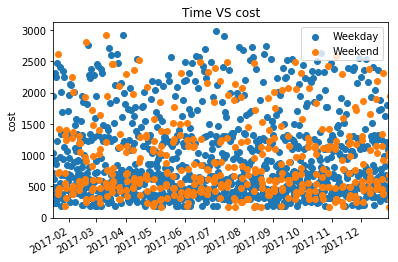

In [100]:
for feature in ['Sessions', 'Transactions', 'AOV', 'CPA', 'cost']:
    plot_weekday_feature(df_3, feature)

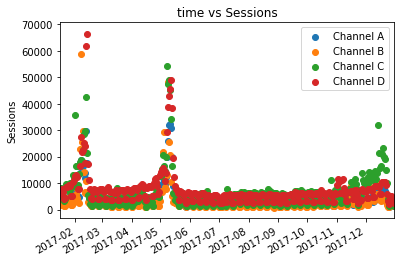

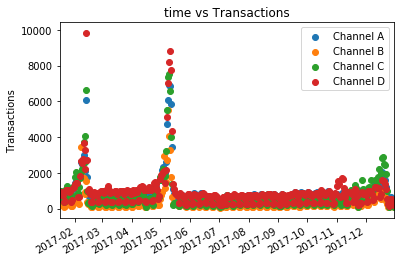

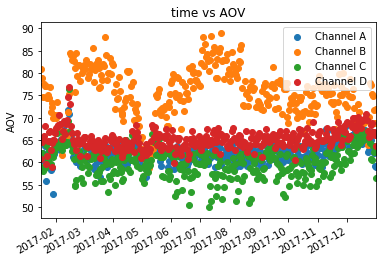

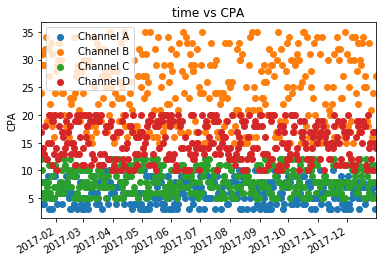

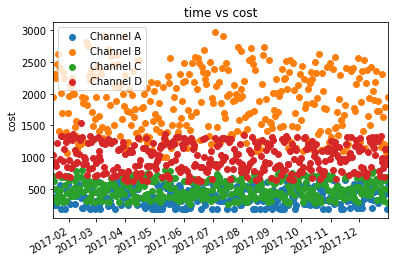

In [114]:
for feature in ['Sessions', 'Transactions', 'AOV', 'CPA', 'cost']:
    plot_channels_feature(df_3, feature)

### Recommendation of which channel(s) the company should focus on in the next year (2018)

#### Channel B
Based on the above

### Cost and Revenue forecast for the entire company (all channels combined) by day for the two weeks leading up to Valentine's Day 2018

In [31]:
df_1_day = df_1.groupby('Date').sum()
df_1_day['Conversion Rate'] = df_1.groupby('Date')["Conversion Rate"].mean()

df_2_day = df_2.groupby('Date').sum()

df_3_day = df_3.groupby('Date').sum()

In [124]:
datetime(2016, 5, 8)

True

Since we don't have enough data to forecast two weeks prior Valentine's Day sales, I am planning to use other major holidays, Mother's day and Christmas's day, to predict the sales behavior of Valentine's day.

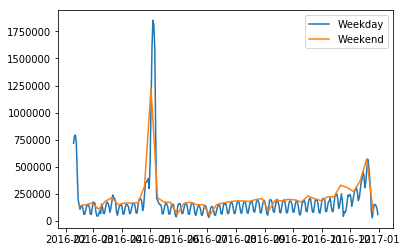

Sessions


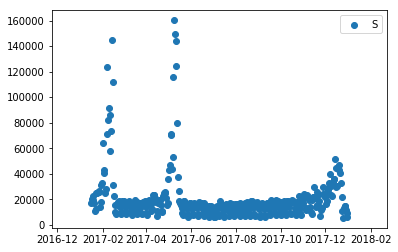

Transactions


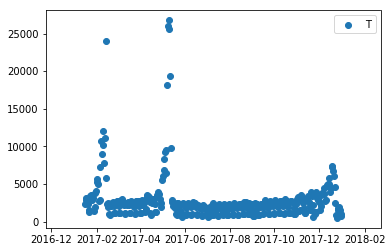

AOV


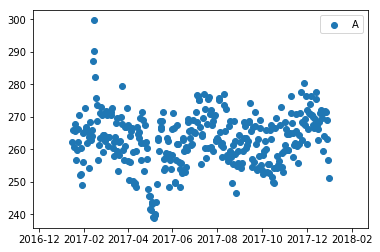

CPA


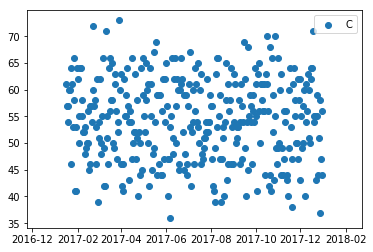

cost


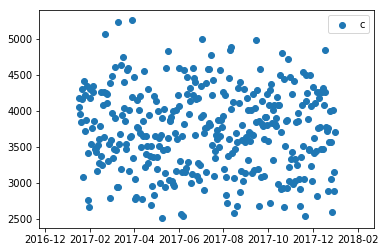

Day


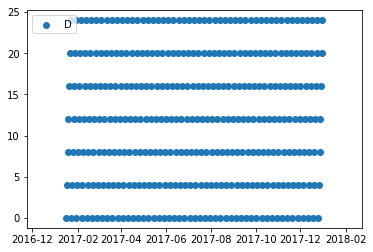

Weekday


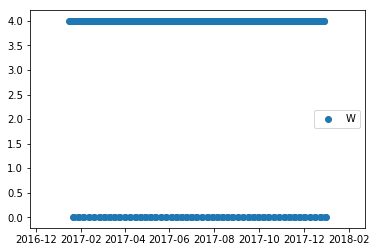

In [113]:
mother_day = [datetime.datetime()]

In [119]:
# Examining Mother's Day 2016
df_3.Date.apply()

AttributeError: 'Series' object has no attribute 'month'

https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet